### Вводное слово

В данном ноутбуке на реальных данных рассмотрено построение модели CAPM (Capital Asset Pricing Model), которая используется для определения справедливой стоимости финансовых активов и на основе которой принимается решение о включении тех или иных активов в уже имеющийся хорошо диверсифицированный порфтель. Несмотря на то, что данная модель является относительно простой, когда-то она находила довольно широкое применение в финансовой сфере (а может ее модифицированные варианты используются  и по сей день).

В основе модели CAPM лежит идея равновесного ценообразования. Предполагается, что доходность всех рисковых финансовых активов на рынке определяется через соотношение спроса и предложения.

В качестве предложения выступает рыночный портфель - портфель, состоящий из всех доступных рсиковых финансовых активов, каждый из которых входит с весом, равным доле его рыночной капитализации по отношению ко всему рынку. При этом границы рынка обычно определяются самим инвестором в зависимости от его целей: можно выделять отдельно рынки по отраслевому признаку (например, рассматривать только акции компаний банковского сектора и смотреть, насколько акции i-го банка чувствительны к изменениям банковского сектора), по географическому, по степени ликвидности бумаг и т. д.

В качестве спроса выступает некоторый оптимальный портфель, который хотят держать все инвесторы на рынке (тут как раз важны предпосылки модели об эффективности рынка, его полной функциональности, гомогенности ожиданий и т. д., поскольку только при их выполнении все инвесторы будут опираться на портфельную теорию и стремиться к единому портфелю). В рамках данной модели под таким портфелем понимается порфтель, лежащий на границе эффективности Марковица, через который проходит линия рынка капитала (CML). Поэтому этот оптимальный портфель называют касательным порфтелем (линия рынка капитала проходит через безрисковую доходность и касается границы эффективности Марковица). Стоит отметить, что одинаковый касательный портфель у всех инвесторов не означает, что все инвесторы гомогенны с точки зрения аппетита к риску (именно к риску, который невозможно диверсифицировать): рискофобы просто будут держать в своем портфеле безрисковый актив с большим весом, по сравнению с рискофилами, и с меньшим - в касательном портфеле.

### Определение области исследования и общий план работы

В качестве рынка рассматриваются самые высоколиквидные акции Московской биржи (голубые фишки). Всего при формировании касательного порфтеля рассмотрено 15 акций. При этом в качестве прокси рынка взят Индекс голубых фишек Московской биржи (MOEXBC). В качестве безрискового актива была взята ключевая ставка Банка России (более подробно о данном решении написано далее).

Данные по Индексу голубых фишек Московской биржи взяты с сайта Московской биржи. Данные по голубым фишкам были выгружены через терминал QUIK с помощью библиотеки QuikPy, позволяющей с помощью Python выполнять LUA скрипты.

**Построение модели CAPM будет проходить в следующей последовательности:**
1. Подготовка данных (чтение данных, получение еженедельных доходностей);
2. Построение границы эффективности Марковица;
3. Добавление безрискового актива, построение линии рынка капитала (CML) и идентификация касательного портфеля;
4. Расчет бета-коэффициентов для каждой акции, определение бета-коэффициента касательного портфеля и построение линии рынка ценных бумаг (SML).

### Подготовка к работе

###### Импорт библиотек

In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from pandas import Timestamp
import datetime
from statistics import correlation, covariance
from itertools import combinations, permutations
from scipy.optimize import Bounds, minimize, LinearConstraint, fsolve
from functools import reduce
import scipy.interpolate as sci
from itertools import product
from scipy.stats import norm

###### Настройка путей, наименований и периодов

In [2]:
PATH = os.path.abspath(os.curdir)
PATH_DATA = PATH + '\\Data\\'

names_share = ('GAZP', 'LKOH', 'SBER', 'GMKN', 'NVTK', 'YNDX', 'ROSN', 'PLZL', 'MGNT',
              'TATN', 'TCSG', 'SNGS', 'POLY', 'ALRS', 'NLMK')

name_market = 'MOEXBC'

time_period = ['2020-01-03', '2020-12-30']

###### Функции чтения данных и их предобработка

In [3]:
# Чтение
def txt_frame(path):
    with open(path) as f:
        txt_list = f.read().splitlines()
        data = pd.DataFrame(columns = re.split(r'\t+', txt_list[0]))
        for i in range(1, len(txt_list)):
            data.loc[i-1, :] = re.split(r'\t+', txt_list[i])
        return data

# Получение еженедельных доходностей 
def r_week(data: list):
    dict_week = {}
    for k in data:
        list_r = []
        list_date = []
        data_week = globals()[k].copy()
        data_week['year'] = data_week['datetime'].dt.isocalendar().year
        data_week['week'] = data_week['datetime'].dt.isocalendar().week
        for i in sorted(set(data_week['year'])):
            data_week_i = data_week[data_week['year'] == i].copy()
            for j in sorted(set(data_week_i['week'])):
                data_week_i_j = data_week_i[data_week_i['week'] == j].copy()
                r_i_j = ((data_week_i_j.iloc[-1]['close'] - data_week_i_j.iloc[0]['open']) / data_week_i_j.iloc[0]['open'])
                list_r.append(r_i_j)
                list_date.append(data_week_i_j.iloc[0]['datetime'])
        dict_week[k] = pd.DataFrame(columns=['datetime', 'r'], data=zip(list_date, list_r), index=list_date)
    return dict_week

###### Чтение данных, получение еженедельных доходностей и визуализация

In [4]:
for i in names_share:
    path_full = PATH_DATA + 'TQBR.' + i + '_D1.txt'
    data_var = txt_frame(path_full)
    date = 'datetime'
    indicators = ['open', 'high', 'low', 'close', 'volume']
    data_var[indicators] = data_var[indicators].astype(float)
    data_var[date] = [str(i)[0:10] for i in list(data_var[date])]
    data_var[date] = [Timestamp(datetime.datetime.strptime(str(data_var.loc[i, date]), "%d.%m.%Y").strftime("%Y-%m-%d")) for i in range(0, len(data_var))]
    data_var.index = data_var[date]
    blue_chip_data = i + '=data_var'
    exec(blue_chip_data)

MOEXBC = pd.read_excel(PATH_DATA + name_market + '.xlsx')
MOEXBC.index = MOEXBC['datetime']


dict_weeks_r = r_week(names_share)

In [5]:
# Еженедельная доходность "голубых фишек" в одной таблице
table_weeks_r_period = pd.DataFrame(columns = dict_weeks_r.keys())

for i in table_weeks_r_period.columns:
    table_weeks_r_period[i] = dict_weeks_r[i].loc[time_period[0]:time_period[1], 'r'].copy()

# Еженедельная доходность рынка
market_weeks_r_period = r_week([name_market])[name_market].loc[time_period[0]:time_period[1], 'r'].copy()

In [6]:
table_weeks_r_period.head()

,GAZP,LKOH,SBER,GMKN,NVTK,YNDX,ROSN,PLZL,MGNT,TATN,TCSG,SNGS,POLY,ALRS,NLMK
2020-01-03,-0.000694,0.014589,-0.003867,0.010811,-0.000158,-0.010248,0.006942,0.015187,0.001162,0.012647,0.011540,0.015617,0.011141,0.008390,0.003612
2020-01-06,-0.027413,0.030159,0.013503,0.021375,0.030599,0.015881,0.031590,-0.020353,-0.037826,0.023119,0.043582,0.058512,-0.014070,0.046280,-0.006090
2020-01-13,0.011446,0.029729,0.016260,0.080522,-0.045033,0.021289,0.017833,0.022933,0.087988,0.013267,0.058212,-0.004167,0.024771,0.024654,0.043200
2020-01-20,-0.069272,-0.011940,0.008701,-0.027895,-0.042841,0.002508,-0.028689,0.006486,0.042857,-0.020315,-0.035302,-0.107978,0.023575,-0.009956,-0.035006
2020-01-27,-0.035319,0.001606,-0.033716,-0.006591,-0.032971,0.033523,0.024411,0.041933,-0.006928,-0.032176,0.061222,-0.023332,0.044191,-0.104411,-0.043129


In [7]:
# Функция для задания нормального распределения
def norm_graph(data):
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim(left = min(data) - np.exp(-5), right=max(data) + np.exp(-5))
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    return x, p

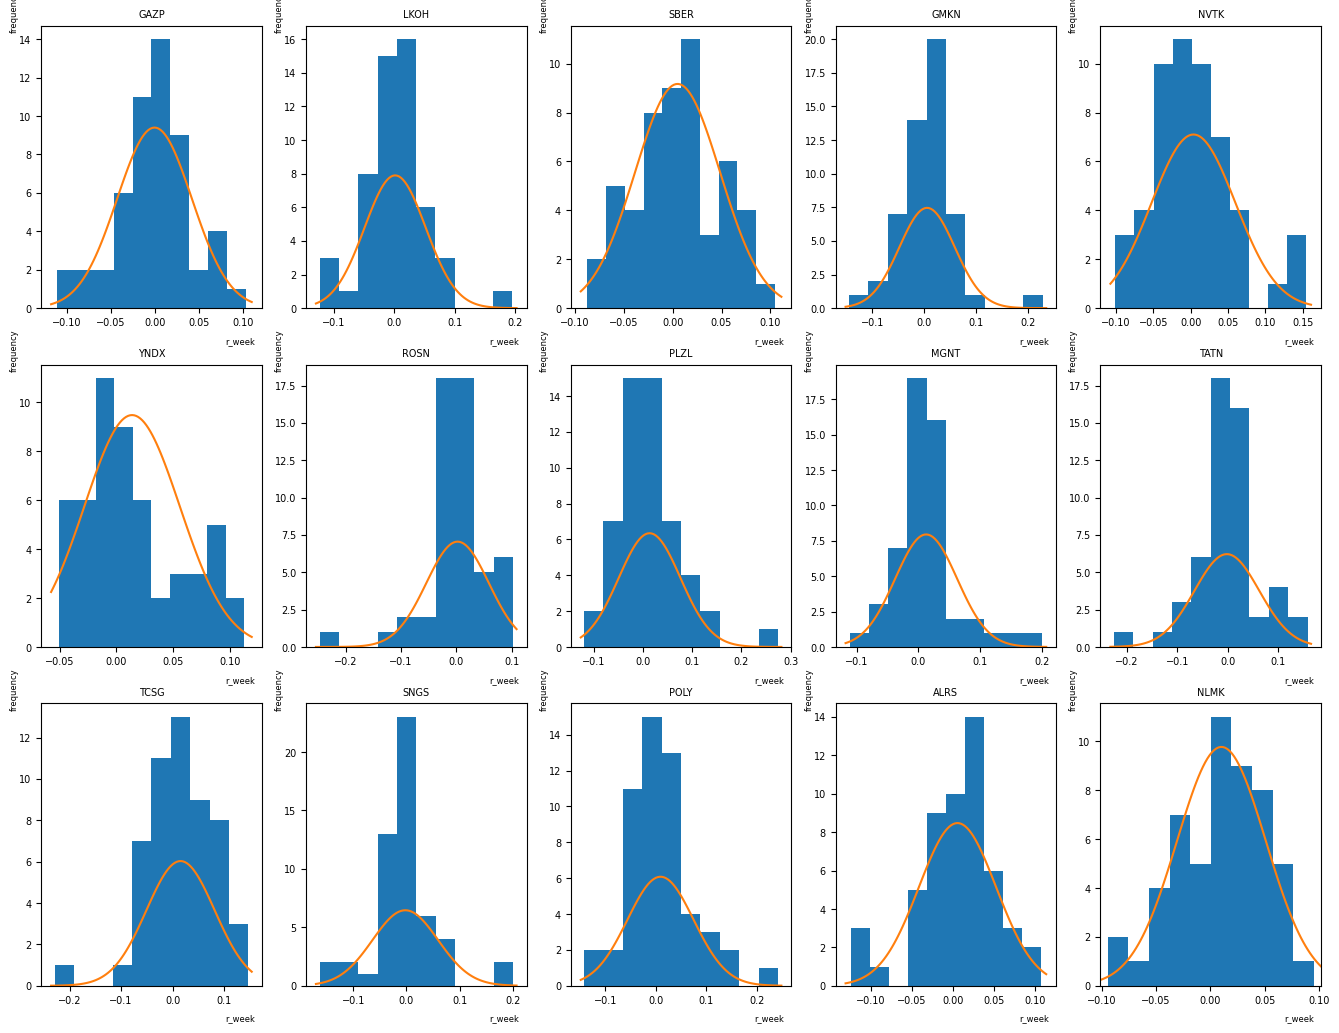

In [8]:
fig, axs = plt.subplots(nrows=3 , ncols=5)

k = 0
for i in range(0, 3):
    for j in range(0, 5):
        axs[i, j].hist(table_weeks_r_period.iloc[:, k])
        axs[i, j].tick_params(labelsize = 7)
        axs[i, j].set_title(table_weeks_r_period.columns[k], fontsize = 7)
        axs[i, j].set_xlabel("r_week", fontsize = 6)
        axs[i, j].xaxis.set_label_coords (.9, -.1) 
        axs[i, j].set_ylabel("frequency", fontsize = 6)
        axs[i, j].yaxis.set_label_coords (-.1, 1.05) 
        # Рисуем нормальное распределение
        x_k, p_k = norm_graph(table_weeks_r_period.iloc[:, k])
        axs[i, j].plot(x_k, p_k)
        
        k = k + 1

plt.subplots_adjust(right=5, left=3, bottom = 2, top = 4)
plt.show()

Из рисунка видно, что в большинстве случаев распределение недельных доходнсотей по рассмотренным бумагам отдаленно похоже на нормальное распределение (исключение составляет YNDX и ROSN).

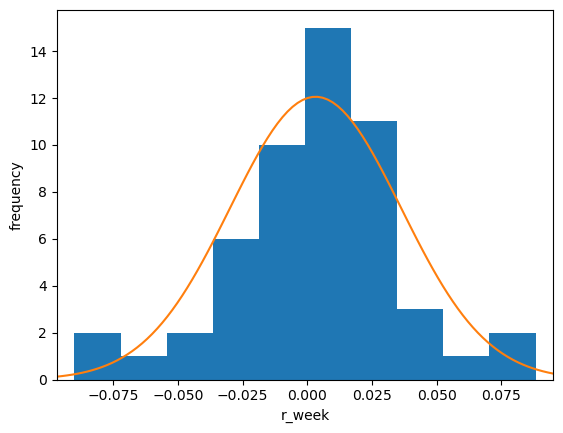

In [9]:
plt.hist(market_weeks_r_period)
plt.xlabel('r_week')
plt.ylabel('frequency')
x_k, p_k = norm_graph(market_weeks_r_period)
plt.plot(x_k, p_k)
plt.show()

Недельные доходности рынка также имеют явные очертания нормального распределения.

### ПОСТРОЕНИЕ ГРАНИЦЫ ЭФФЕКТИВНОСТИ МАРКОВИЦА

###### Функции для оптимизации портфеля

In [10]:
def value(x, S):
    # S - ковариационная матрица
    # x - вектор весов бумаг
    return np.sqrt(x.T @ S @ x)

def optimize_portfolio(r, x, mu, S, options):
    # r - значение доходности, для которой минимизируем риск
    # x - начальные веса, с которыми акции входят в портфель
    # mu - средние доходности бумаг 
    # S - ковариационная матрица
    # options - опции решения оптимизационной задачи
    mu_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(mu @ x.T) - r
                }
    sum_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1
                }
    #bnds = Bounds(lb = np.zeros_like(x), ub = np.ones_like(x) * np.inf)
    bnds = Bounds(lb = np.ones_like(x) * np.NINF, ub = np.ones_like(x) * np.Inf)

    res = minimize(fun = value, x0 = x, args = (S), method='SLSQP', constraints=[mu_cons, sum_cons],
                   bounds=bnds, options = options)
    return res

При моделировании задачи условной оптимизации были введены следующие ограничения:
1. Значение доходности, для которой минимизируется среднеквадратичное отклонение на i-ой итерации;
2. Сумма весов входящих в портфель бумаг равна 1;
3. Индивидуальный вес каждой ценной бумаги, входящей в портфель, может быть от минус бесконечности, до плюс бесконечности.

Поскольку модель CAPM предполагает, что рынок совершенен и обладает полной функциональностью (например, нет ограничений на "короткие" позиции), то вес каждой бумаги может быть любым (отрицательный вес бумаги в порфтеле означает, что по ней открыта "короткая" позиция) - главное, чтобы сумма всех весов равнялась 1.

In [11]:
weight_0 = np.array([1 / len(table_weeks_r_period.columns)] * len(table_weeks_r_period.columns)) # начальные веса
S = table_weeks_r_period.cov() # ковариационая матрица
mu = np.array([np.mean(table_weeks_r_period[i]) for i in table_weeks_r_period.columns]) # вектор средних доходностей

options = dict()
options['maxiter'] = 100000 # Максимальное количество итераций
options['disp'] = True # Написать сообщение о сходимости

In [12]:
range_r = np.arange(0, max(mu), 0.0001) # Задаем интервал и шаг доходности для построения портфелей
risk_return_curve = []
for i in range_r:
    risk_return_curve.append(optimize_portfolio(i, weight_0, mu, S, options))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.032751424224164015
            Iterations: 35
            Function evaluations: 560
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03261742080715932
            Iterations: 35
            Function evaluations: 560
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03248422380397726
            Iterations: 35
            Function evaluations: 560
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.032351842591058236
            Iterations: 35
            Function evaluations: 560
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03222028655457377
            Iterations: 35
            F

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.028218837507531527
            Iterations: 32
            Function evaluations: 512
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0281245207545669
            Iterations: 32
            Function evaluations: 512
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02803068608199216
            Iterations: 32
            Function evaluations: 513
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.027938682659073618
            Iterations: 33
            Function evaluations: 528
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.027847938590302303
            Iterations: 33
            F

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02556779331553089
            Iterations: 25
            Function evaluations: 400
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.025529886450587604
            Iterations: 25
            Function evaluations: 401
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.025494158025004467
            Iterations: 25
            Function evaluations: 401
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.025463671489366034
            Iterations: 22
            Function evaluations: 353
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.025430603164951028
            Iterations: 22
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02539613448834496
            Iterations: 23
            Function evaluations: 368
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.025426604796029588
            Iterations: 23
            Function evaluations: 368
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.025458790342934592
            Iterations: 23
            Function evaluations: 368
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02549268741286691
            Iterations: 23
            Function evaluations: 368
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02552829221601567
            Iterations: 23
            F

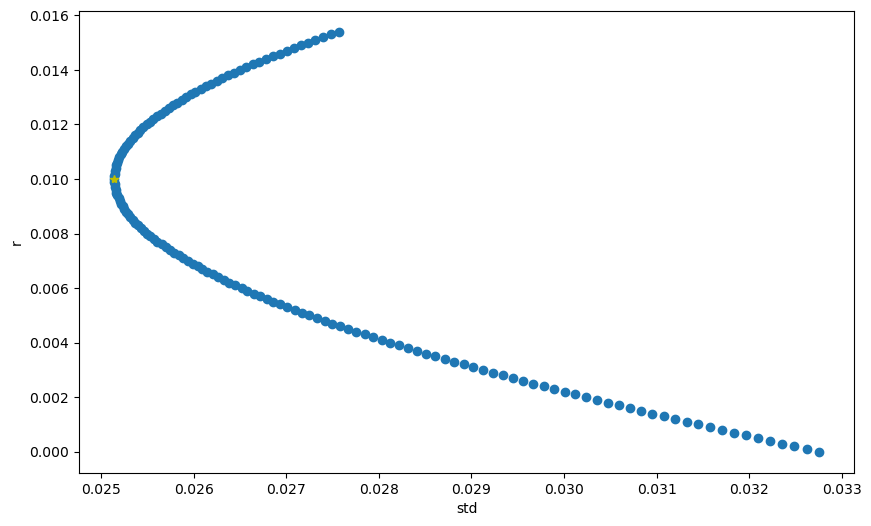

In [13]:
ind_min_std = np.argmin([risk_return_curve[i].fun for i in range(0, len(risk_return_curve))])
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = [risk_return_curve[i].fun for i in range(0, len(risk_return_curve))], y = range_r)
plt.xlabel("std")
plt.ylabel("r")
plt.plot([risk_return_curve[i].fun for i in range(0, len(risk_return_curve))][ind_min_std],
         range_r[ind_min_std], 'y*')
plt.show()

Звездочкой обозначена точка, с которой начинается граница эффективности Марковица. То есть ниже этой точки расположены порфтели, у которых среднеквадратичное отклонения больше, а средняя доходность такая же, что и у порфтелей, расположенных на границе эффективности. То есть портфели, которые расположены ниже звездочки, формировать бессмысленно.

Вместе с тем при формировании портфелей мы не учитывали того факта, что в экономике может быть ненулевая безрисковая доходность. 

### ДОБАВЛЕНИЕ БЕЗРИСКОВОГО АКТИВА. ПОСТРОЕНИЕ CML.

##### Решение о выборе безрисковой доходности

За безрисковую доходность было взято значение ключевой ставки Банка России по состоянию на 03.01.2020 (дату формирования порфтеля).

In [14]:
r_free = 0.0625 

# Нормировка безрисковой доходности
r_free_week = r_free / len(table_weeks_r_period)

**Cтоит отметить следующие особенности, касающиеся безрисковой доходности, в качестве которой мы взяли ключевую ставку Банка России:**

1. Ключевая ставка Банка России далеко не идеальна, чтобы использовать ее как безрисковую доходность. Особенно это касается случая, когда порфтель формирует частный инвестор. Более правильно брать доходности по тем инструментам, которые доступны этому инвестору. При этом эти инструменты должны обладать самыми минимальными рисками, а их срок должен примерно совпадать со сроком, на который инвестор планирует формировать портфель. В качестве такого инструмента может выступать вклад, открытый в банке с очень хорошими показателями обязательных нормативов Банка России и прочими положительными сигналами надежности.

2. Предполагается, что по безрисковой доходности можно как размещать, так и привлекать денежные средства. Это очень сильное предположение (особенно для частного инвестора, поскольку разница в ставках по вкладам и кредитам для физических лиц существенна). Тем не менее, в данном случае для простоты мы исходим из такого предположения.

3. При осуществлении нормировки безрисковой доходности (приведении ее к недельной размерности) мы предполагаем, что понедельное реинвестирование процентов отсутствует (отсутствует понедельная капитализация процентов). Иначе нормировка должна быть осуществлена через формулу сложных процентов.

4. Предполагается, что доходность безрискового актива имеет нулевую дисперсию (поэтому и безрисковый), а также нулевую корреляцию с доходностями любых рисковых активов.

##### Визуализация безрисковой доходности и границы эффективности

In [15]:
risk_return_curve_eff = risk_return_curve[ind_min_std:]
range_r_eff = range_r[ind_min_std:]
range_std_eff = np.array([risk_return_curve_eff[i].fun for i in range(0, len(risk_return_curve_eff))])

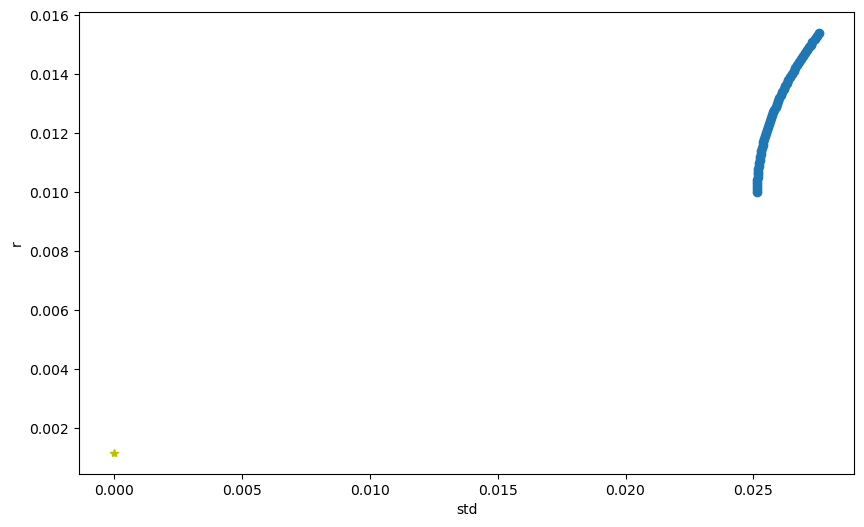

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = range_std_eff, y = range_r_eff)
plt.xlabel("std")
plt.ylabel("r")
plt.plot(0, r_free_week, 'y*')
plt.show()

В данном случае визуализация безрисковой доходности и границы эффективности полезна, поскольку используемый далее оптимизационный алгоритм довольно чувствителен к начальным условиям. Глядя на рисунок можно понять, что абсцисса точки касания границы эффективности и прямой, проходящей через безрисковую доходность, будет находиться в диапазоне [0.025; 0.030]. При этом угол наклона касательной будет в диапазоне [0.012/0.025; 0.016/0.030].

###### Задаем функции для определения касательной, а также функции для выбора оптимального начального условия

In [17]:
def f(x):
    #Функция границы эффективности (аппроксимация сплайнами)
    return sci.splev(x, tck, der=0)

def df(x):
    #Первая производная функции границы эффективности
    return sci.splev(x, tck, der=1)

def equations(p, r_f):
    eq1 = r_f - p[0] # точка пересечения с ординатой
    eq2 = r_f + p[1] * p[2] - f(p[2]) # точка пересечения прямой и границы эффективности
    eq3 = p[1] - df(p[2]) # условие касания (равенство производной границы эффективности и прямой в точке касания - у прямой это коэффициент)
    return eq1, eq2, eq3 # возвращает значения p

def graph_tang(first_cond: float, second_cond_range:list, third_cond_range:list):
    # first_cond - точка пересечения с ординатой
    # second_cond_range - возможный диапазон тангенса угла наклона  CML
    # third_cond_range - возможный диапазон абсциссы точки касания CML и границы эффективности
    list_opt = []
    list_0_all = []
    for i in np.arange(min(third_cond_range), max(third_cond_range) + np.exp(-10), (max(third_cond_range) - min(third_cond_range)) / 2):
        for j in np.arange(min(second_cond_range), max(second_cond_range) + np.exp(-10), (max(second_cond_range) - min(second_cond_range)) / 2):
            list_opt.append(fsolve(func = equations, x0 = [first_cond, i, j], args = first_cond))
            list_0_all.append([first_cond, round(j, 4), round(i, 4)])
    return list_opt, list_0_all

###### Определение начальных условий и выбор наиболее оптимальных значений

Начальные условия для оптимизации:
1. Точка пересечения с ординатой;
2. Тангенс угла наклона CML;
3. Абсцисса точки касания CML и границы эффективности.

In [18]:
tck = sci.splrep(range_std_eff, range_r_eff)

list_condit_opt, list_condit_0 = graph_tang(first_cond = r_free_week, second_cond_range = 
                                            [0.012 / 0.025, 0.016 / 0.030], third_cond_range = [0.025, 0.030])

C:\Users\umche\.conda\envs\GitHub_env\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


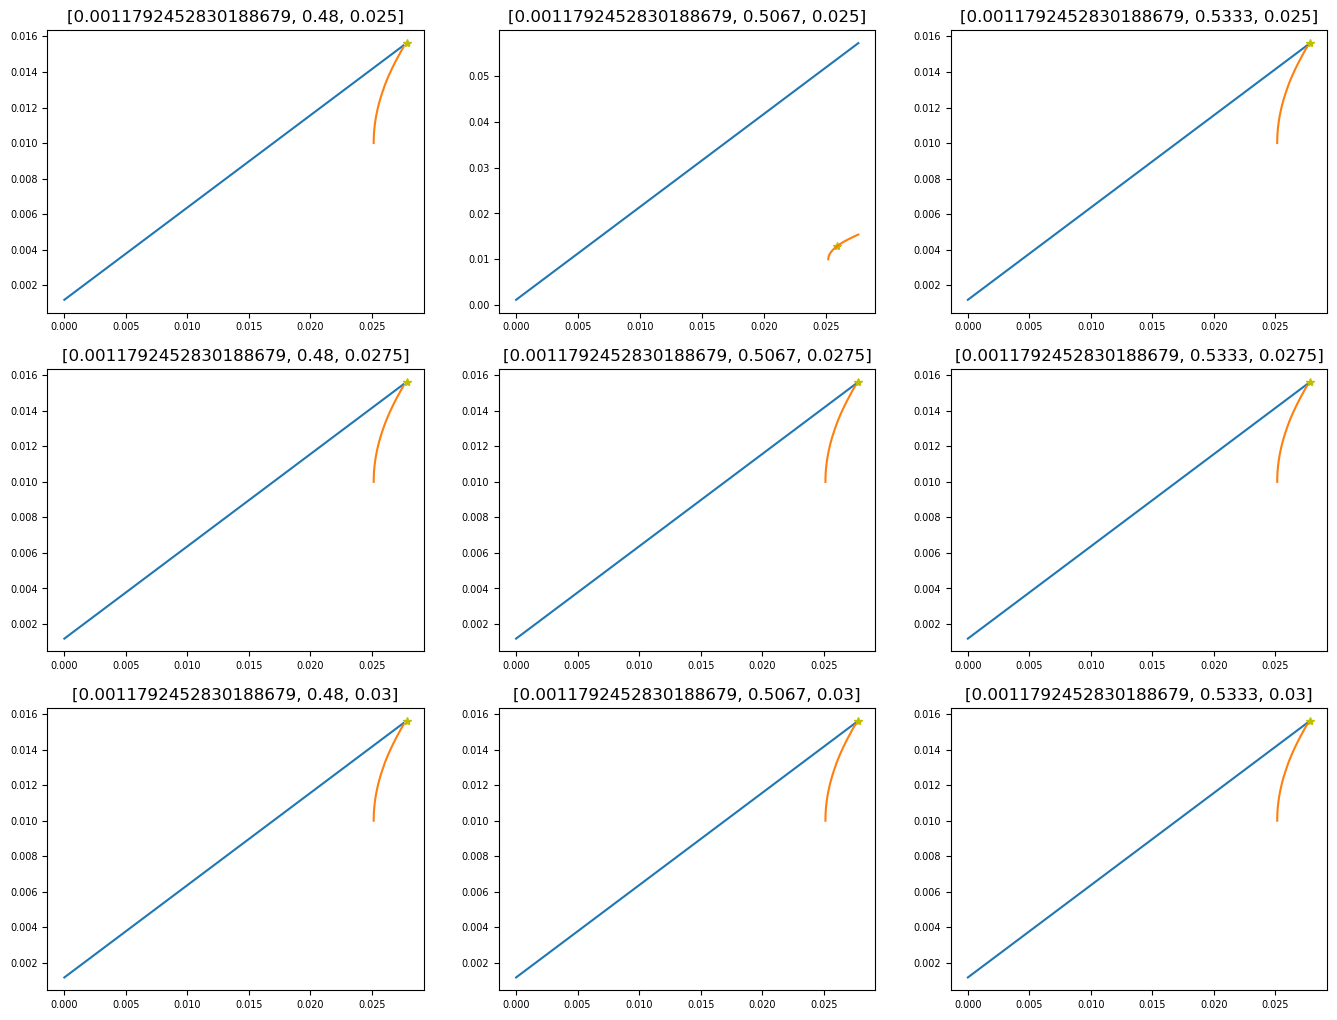

In [19]:
cx = np.linspace(0.00, max(range_std_eff))

fig, axs = plt.subplots(nrows=3 , ncols=3)

for i in range(0, len(list_condit_opt)):
    comb_i = list(product([0, 1, 2], repeat = 2))[i]
    axs[comb_i[0], comb_i[1]].plot(cx, list_condit_opt[i][0] + list_condit_opt[i][1] * cx)
    axs[comb_i[0], comb_i[1]].plot(list_condit_opt[i][2], f(list_condit_opt[i][2]), 'y*')
    axs[comb_i[0], comb_i[1]].plot(range_std_eff, range_r_eff)
    axs[comb_i[0], comb_i[1]].tick_params(labelsize = 7)
    axs[comb_i[0], comb_i[1]].set_title(list_condit_0[i])

plt.subplots_adjust(right=5, left=3, bottom = 2, top = 4)

Видно, что только в одном случае из 9 начальное приближение было неудачным. Поэтому в качестве начального приближения для решения задачи оптимизации можно взять, к примеру, тангенс угла наклона = 0.5333 и абсциссу точки касания CML и границы эффективности = 0.03.

###### Решение задачи оптимизации с выбранным начальным условием

In [20]:
list_0 = [r_free_week, 0.5333, 0.03]

opt = fsolve(func = equations, x0 = list_0, args = r_free_week)

###### Касательный портфель и линия рынка капитала (CML)

In [21]:
index_tangent = [abs(risk_return_curve_eff[i].fun - opt[2]) for i in range(0, len(risk_return_curve_eff))].index(
    min([abs(risk_return_curve_eff[i].fun - opt[2]) for i in range(0, len(risk_return_curve_eff))]))

table_weeks_r_period.columns
tangent_portfolio = dict(zip(table_weeks_r_period.columns, risk_return_curve[index_tangent].x))
print('Доли голубых фишек в касательном портфеле:')
tangent_portfolio

Доли голубых фишек в касательном портфеле:


{'GAZP': 0.5069040486964537,
 'LKOH': -0.023339299262071962,
 'SBER': 0.225314372345962,
 'GMKN': 0.021130775714253737,
 'NVTK': -0.15265368323887546,
 'YNDX': 0.3099209219144649,
 'ROSN': 0.16007239105129337,
 'PLZL': -0.028101063339219603,
 'MGNT': -0.11021903455248122,
 'TATN': -0.09400360089826029,
 'TCSG': -0.07822083180379524,
 'SNGS': -0.06949766869392511,
 'POLY': 0.20935620925157072,
 'ALRS': 0.05091596189994551,
 'NLMK': 0.07242050091468497}

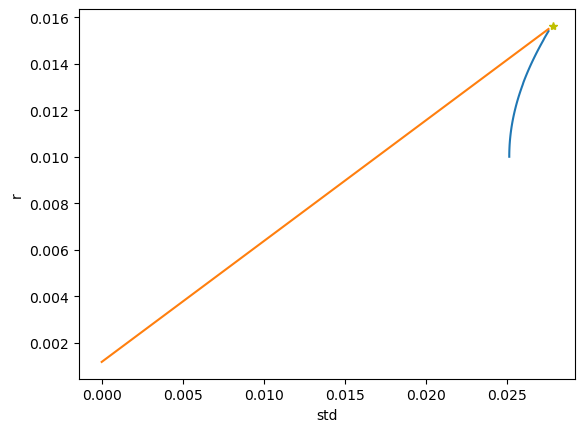

Точка пересечения прямой с вертикальной осью: 0.0011792452830188679
Тангенс угла наклона прямой: 0.5192442446822282
Координата точки касания на горизонтальной оси: 0.027818709513269393


In [22]:
plt.plot(range_std_eff, range_r_eff)
cx = np.linspace(0.00, max(range_std_eff))
plt.xlabel("std")
plt.ylabel("r")
plt.plot(cx, opt[0] + opt[1] * cx)
plt.plot(opt[2], f(opt[2]), 'y*')
plt.show()

print('Точка пересечения прямой с вертикальной осью: ' + str(opt[0]))
print('Тангенс угла наклона прямой: ' + str(opt[1]))
print('Координата точки касания на горизонтальной оси: ' + str(opt[2]))

Видно, что касательный портфель оказался портфелем, который обладает наибольшей доходностью на границе эффективности Марковица. Дополнительные исследования показали, что если в моделировании задачи условной оптимизации (Блок "ПОСТРОЕНИЕ ГРАНИЦЫ ЭФФЕКТИВНОСТИ МАРКОВИЦА") наложить ограничения на индивидуальные веса бумаг от 0 до плюс бесконечности (то есть запретить открывать короткие позиции по рисковым активам), то касательный портфель будет лежать на середине границы эффективности Марковица, а сама эта граница эффективности будет не такой крутой. То есть получается так, что наличие возможности открывать "короткие" позиции дает возможность получить более высокую доходность (однако и риск выше).

Таким образом мы получили линию рынка капитала (CML), на которой расположены все наиболее эффективные комбинации касательного портфеля и безрискового актива. Если инвестор инвестирует в комбинацию, расположенную на линии рынка капитала левее точки касания CML с эффективной границей Марковица, то в итоговом портфеле и безрисковый актив и касательный портфель входят с положительными весами. Такой инвестор менее склонен к риску. Если же инвестор формирует портфель, расположенный правее точки касания, то такой портфель будет состоять из безрискового актива с отрицательным весом и из касательного портфеля с весом больше 1 (то есть инвестор занял "короткую" позицию по безрисковому активу и "длинную" по касательному портфелю). Такой инвестор более склонен к риску.

### ОПРЕДЕЛЕНИЕ SML - ЛИНИЯ РЫНКА ЦЕННЫХ БУМАГ

###### Функция линии рынка ценных бумаг и функция расчета бета-коэффициентов для отдельных голубых фишек

In [23]:
def SML_curve(r_free, beta_SML, beta_i):
    return r_free + beta_SML * beta_i

def beta_share(market_weeks_r_period, share_weeks_r_period):
    return covariance(share_weeks_r_period, market_weeks_r_period) / np.var(market_weeks_r_period)

###### Расчет бета-коэффициентов для отдельных голубых фишек

In [24]:
beta_r_shares = dict()
for i in table_weeks_r_period.columns:
    beta_r_shares[i] = beta_share(market_weeks_r_period, table_weeks_r_period[i])

print('Бета-коэффициенты отдельных голубых фишек:')
beta_r_shares

Бета-коэффициенты отдельных голубых фишек:


{'GAZP': 1.0338756712649284,
 'LKOH': 1.3609548575887038,
 'SBER': 0.8719073790281776,
 'GMKN': 0.9586762138956053,
 'NVTK': 1.3800131458824805,
 'YNDX': 0.4319000978157092,
 'ROSN': 1.3675709985838767,
 'PLZL': 0.4785953474261433,
 'MGNT': 0.841980635220801,
 'TATN': 1.6381621852552053,
 'TCSG': 0.5469097885415214,
 'SNGS': 1.4775107783519854,
 'POLY': 0.5902867460094279,
 'ALRS': 0.8782196763643553,
 'NLMK': 0.7542854563080889}

###### Построение линии рынка ценных бумаг (SML)

In [25]:
beta_SML = np.array(list(beta_r_shares.values())).T @ np.array(list(tangent_portfolio.values()))

r_SML = mu.T @ np.array(list(tangent_portfolio.values()))

tangent_SML = (r_SML - r_free_week) / (beta_SML - 0)

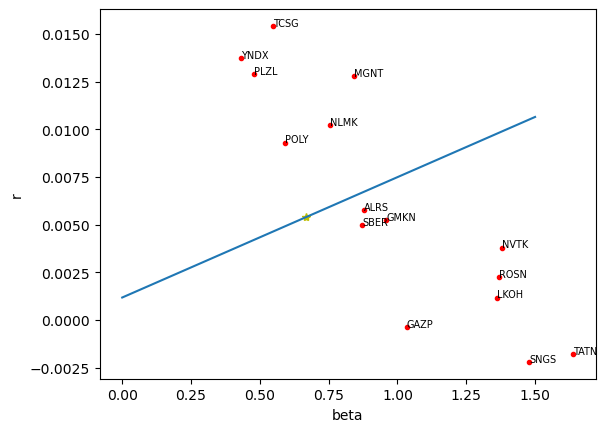

In [26]:
SML_beta_i = np.linspace(0.0, 1.5)
plt.xlabel("beta")
plt.ylabel("r")
plt.plot(beta_SML, r_SML, 'y*')
plt.plot(SML_beta_i, r_free_week + tangent_SML * SML_beta_i)
plt.plot(beta_r_shares.values(), mu, 'r.')

for i, txt in enumerate(list(beta_r_shares.keys())):
    plt.annotate(txt, (list(beta_r_shares.values())[i], mu[i]), fontsize=7)

plt.show()

In [27]:
SML_curve(r_free_week, tangent_SML, 1)

0.007494548958612448

Таким образом, если у актива бета-коэффициент к рассматриваемому рынку равен 1, то справедливая средняя еженедельная доходность такого актива должна быть 0.007494548958612448.

Звездочкой показан касательный портфель. Красными точками отмечены те 15 голубых фишек, которые использовались при формировании касательного портфеля.

Гляда на рисунок и соглашаясь со всеми предпосылками модели CAPM можно сделать следующий вывод: те бумаги, которые расположены выше линии рынка ценых бумаг (SML) являются недооцененными (поскольку их фактическая доходность для заданного уровня риска выше справедливой доходности SML, то фактическая цена таких бумаг ниже их справедливой цены с точки зрения модели CAPM). Следовательно, такие бумаги следует включить в свой диверсифицированный портфель (например, можно включить YNDX, PLZL, TCSG и т. д.). И наоборот, бумаги, расположенные ниже линии рынка ценных бумаг (SML), переоценены (их фактическая доходность ниже справедливой), поэтому их не следует включать в свой портфель (например, SNGS, TATN, LKOH и другие).

Тем не менее модель CAPM имеет большое количесто предпосылок и ограничений, которые просто не выполняются в реальной жизни. При этом имеется большое количество работ, которые эмпирически показывают их несостоятельность. Например, в ряде работ было показано следующее: 
1. Бета-коэффициенты одной и той же бумаги при падении рынка и при росте не являются одинаковыми;
2. Инвесторов интересует не только рыночный риск, но и другие виды рисков;
3. Существенная роль трансакционных издержек при принятии решения о формировании портфеля (налоги, разница безрисковых ставок между размещением и заимствованием, комиссии при открытии "коротких" позиций) и т. д.

Следовательно, в современных условиях при принятии решения о включении той или иной бумаги в портфель базовой модели CAPM недостаточно. Однако идеи, лежащие в ее основе, составили прочный фундамент для более продвинутых подходов и понимание базовой модели CAPM является полезным для более глубокого погружения в данную область.